In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
pd.options.display.max_columns = None
pd.options.display.max_rows = None
matplotlib.rcParams.update({'font.size': 22})
from pytz import timezone as tz
import gluonts

In [2]:
data_path = "./data/"
data_freq = "H"
patience = 10
learning_rate = 0.0001

start_train_date = datetime(2017, 1, 1)
end_train_date = datetime(2018, 12, 31)
test_date = datetime(2019, 1, 1)
nb_hours_pred = 2*7*24

In [3]:
df = pd.read_csv(data_path + "eco2mix-regional-cons-def.csv", sep=";",
                parse_dates=["Date - Heure"],
                usecols=["Région", "Date - Heure", "Consommation (MW)"]).sort_values(
    by=["Région", "Date - Heure"])

In [4]:
df.rename(columns={"Date - Heure": "Date"}, inplace=True)
df.fillna(df.dropna()["Consommation (MW)"].mean(), inplace=True)
df["date_heure"] = df["Date"].apply(lambda x: x + timedelta(minutes=x.minute))
df["date_heure"] = df["date_heure"].apply(lambda x: x.astimezone(tz("UTC")))
df["date_heure"] = df["date_heure"].apply(lambda x: x.fromtimestamp(x.timestamp()))
df.head(3)

Région                       Date  Consommation (MW)  \
1288256  Auvergne-Rhône-Alpes  2013-01-01 00:00:00+01:00        4528.493194   
1288257  Auvergne-Rhône-Alpes  2013-01-01 00:30:00+01:00        8173.000000   
116935   Auvergne-Rhône-Alpes  2013-01-01 01:00:00+01:00        7944.000000   

                 date_heure  
1288256 2013-01-01 00:00:00  
1288257 2013-01-01 01:00:00  
116935  2013-01-01 01:00:00

In [5]:
df_hour = df.groupby(["Région", "date_heure"], as_index=False).agg({"Consommation (MW)": np.sum})
df_hour.head(3)

Région          date_heure  Consommation (MW)
0  Auvergne-Rhône-Alpes 2013-01-01 00:00:00        4528.493194
1  Auvergne-Rhône-Alpes 2013-01-01 01:00:00       16117.000000
2  Auvergne-Rhône-Alpes 2013-01-01 02:00:00       15778.000000

In [6]:
df_dict = {}

for region in pd.unique(df_hour["Région"]):
    df_dict[region] = df_hour[df_hour["Région"]==region].copy().reset_index(drop=True)
    df_dict[region].index = df_dict[region]["date_heure"]
    df_dict[region] = df_dict[region].reindex(
        pd.date_range(start=df_hour["date_heure"].min(), end=df_hour["date_heure"].max(), freq=data_freq)).drop(
        ["date_heure", "Région"], axis=1)

# Fonctions pour entraînement DeepAR

In [7]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

def train_predictor(df_dict, end_train_date, regions_list, target_col, max_epochs, feat_dynamic_cols=None):
    estimator = DeepAREstimator(freq=data_freq, 
                                prediction_length=nb_hours_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate = learning_rate,
                                                learning_rate_decay_factor=0.01, patience=patience),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    if feat_dynamic_cols is not None:
        
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:end_train_date]
                                   for feat_dynamic_col in feat_dynamic_cols] 
             }
            for region in regions_list],
            freq = data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date]
             }
            for region in regions_list],
            freq = data_freq
        )

    predictor = estimator.train(training_data=training_data)
    
    return predictor


def make_predictions(predictor, df_dict, test_date, regions_list, target_col, feat_dynamic_cols=None):
    if feat_dynamic_cols is not None:
        test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:test_date + timedelta(hours=nb_hours_pred)]
                                   for feat_dynamic_col in feat_dynamic_cols]
             }
            for region in regions_list],
            freq = data_freq
            )
    else:
         test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             }
            for region in regions_list],
            freq = data_freq
            )

    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
    
    return list(forecast_it), list(ts_it)


def plot_forecasts(df_dict, test_date, tss, forecasts, past_length, num_plots, figname):
    label_fontsize = 16
    for target, forecast in zip(tss, forecasts):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        
        results_mean = forecast.mean
        ground_truth = df_dict[forecast.item_id]["Consommation (MW)"][
            test_date + timedelta(hours=1):test_date + timedelta(hours=nb_hours_pred)].values
        MAPE = np.mean(np.apply_along_axis(abs, 0, (ground_truth - results_mean) / ground_truth))
        plt.title(forecast.item_id + " MAPE:{}%".format(str(round(100*MAPE, 1))))
        plt.ylabel("Consumption (MW)")
        plt.xlabel("")
        ax.set_xlim([test_date - timedelta(days=nb_hours_pred/24), test_date + timedelta(days=nb_hours_pred/24)])
        ax.set_ylim([12000, 28000])
        xticks = [test_date + timedelta(days=x) for x in [-11, -7, -3, 0, 4, 8, 12]]
        ax.set_xticks(xticks, minor=True)
        ax.set_xticklabels([datetime.strftime(date, "%Y-%m-%d") for date in xticks if date != test_date],
                           minor=True, fontsize=label_fontsize)
        ax.set_xticklabels(["", datetime.strftime(test_date, "%Y-%m-%d"), ""], minor=False,
                           fontsize=label_fontsize)
        yticks = np.arange(14000, 28000, step=2000)
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(x) for x in yticks], fontsize=label_fontsize)
        plt.savefig(figname)
        plt.show()
    
    return MAPE

INFO:root:Using CPU


# Test Île de France

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:38<00:00,  1.29it/s, avg_epoch_loss=10.4]
INFO:root:Epoch[0] Elapsed time 38.828 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.358395
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=9.46]
INFO:root:Epoch[1] Elapsed time 33.693 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.462381
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:34<00:00,  1.46it/s, avg_epoch_loss=9.07]
INFO:root:Epoch[2] Elapsed time 34.173 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.071051
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.47it/s, avg_epoch_loss=8.66]
INFO:root:Epoch[3] Elapsed time 33.934 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.661336
INFO:root:Epo

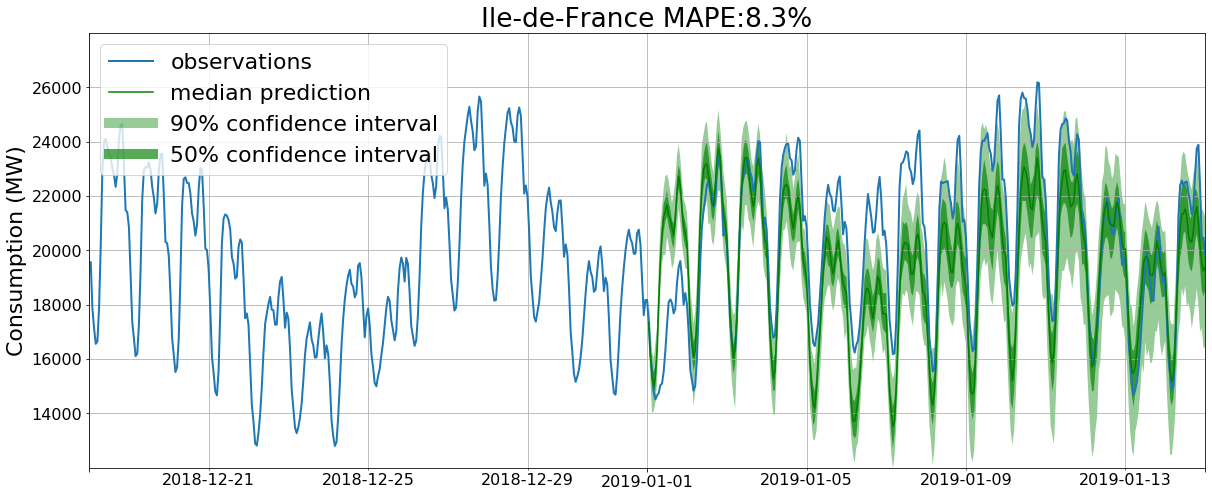

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:38<00:00,  1.31it/s, avg_epoch_loss=10.1]
INFO:root:Epoch[0] Elapsed time 38.304 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.095995
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=9.3] 
INFO:root:Epoch[1] Elapsed time 33.766 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.304217
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=8.8] 
INFO:root:Epoch[2] Elapsed time 32.938 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.801525
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:34<00:00,  1.44it/s, avg_epoch_loss=8.49]
INFO:root:Epoch[3] Elapsed time 34.745 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.494439
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.273251
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[37] Elapsed time 33.750 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.246941
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:35<00:00,  1.40it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[38] Elapsed time 35.703 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.245739
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:36<00:00,  1.36it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[39] Elapsed time 36.675 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.253716
INFO:root:Loading parameters from best epoch (38)
INFO:root:Final loss: 7.245739326477051 (occurred at epoch 38)
INFO:root:End model training


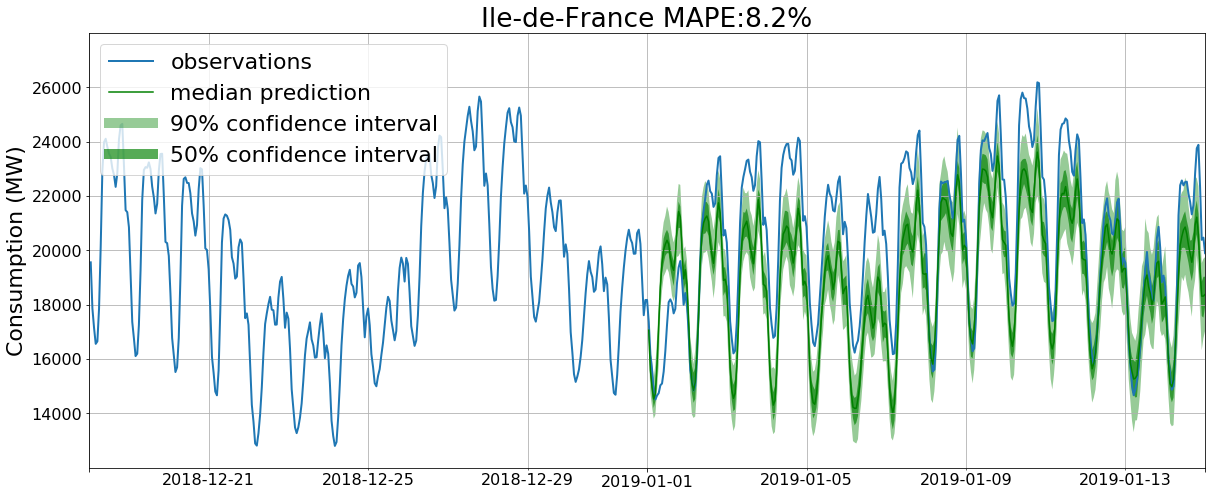

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:42<00:00,  1.17it/s, avg_epoch_loss=10.9]
INFO:root:Epoch[0] Elapsed time 42.592 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.851621
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.35it/s, avg_epoch_loss=9.81]
INFO:root:Epoch[1] Elapsed time 37.114 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.810309
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:35<00:00,  1.42it/s, avg_epoch_loss=9.02]
INFO:root:Epoch[2] Elapsed time 35.145 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.016913
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:35<00:00,  1.41it/s, avg_epoch_loss=8.61]
INFO:root:Epoch[3] Elapsed time 35.396 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.606535
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.213298
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.32it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[37] Elapsed time 37.806 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.212410
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.35it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[38] Elapsed time 37.002 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.192281
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:35<00:00,  1.40it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[39] Elapsed time 35.706 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.171082
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:36<00:00,  1.35it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[40] Elapsed time 36.977 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.174064
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

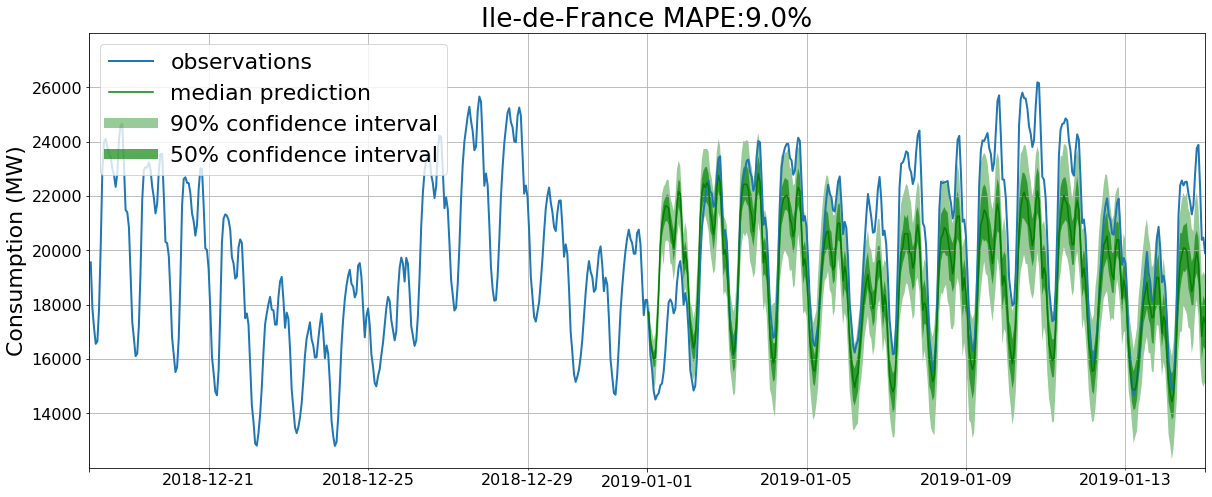

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.34it/s, avg_epoch_loss=9.58]
INFO:root:Epoch[0] Elapsed time 37.318 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.575938
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=8.97]
INFO:root:Epoch[1] Elapsed time 33.181 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.967639
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=8.63]
INFO:root:Epoch[2] Elapsed time 32.718 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.633752
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[3] Elapsed time 33.263 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.385467
INFO:root:Epoc

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.226449
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[37] Elapsed time 32.548 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.209825
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.2] 
INFO:root:Epoch[38] Elapsed time 32.999 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.204425
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[39] Elapsed time 32.537 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.208435
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[40] Elapsed time 33.066 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.194389
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[74] Elapsed time 32.651 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.979368
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[75] Elapsed time 32.845 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.971709
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[76] Elapsed time 33.143 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.977441
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[77] Elapsed time 32.502 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.990481
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=6.98]
INF

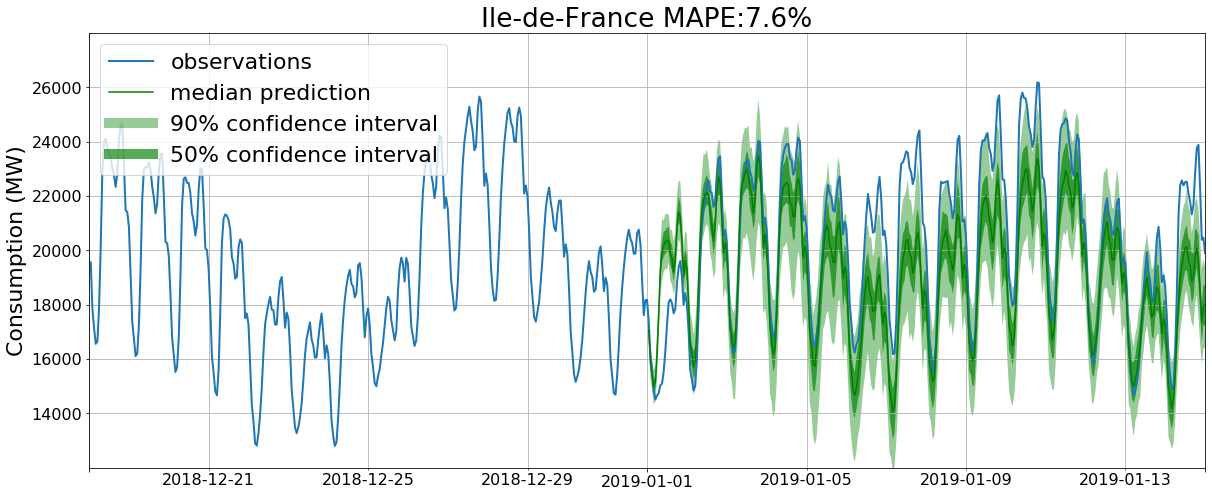

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.34it/s, avg_epoch_loss=10.5]
INFO:root:Epoch[0] Elapsed time 37.313 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.537938
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=9.64]
INFO:root:Epoch[1] Elapsed time 33.301 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.637533
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=9.16]
INFO:root:Epoch[2] Elapsed time 32.813 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.159471
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=8.75]
INFO:root:Epoch[3] Elapsed time 32.875 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.748150
INFO:root:Epo

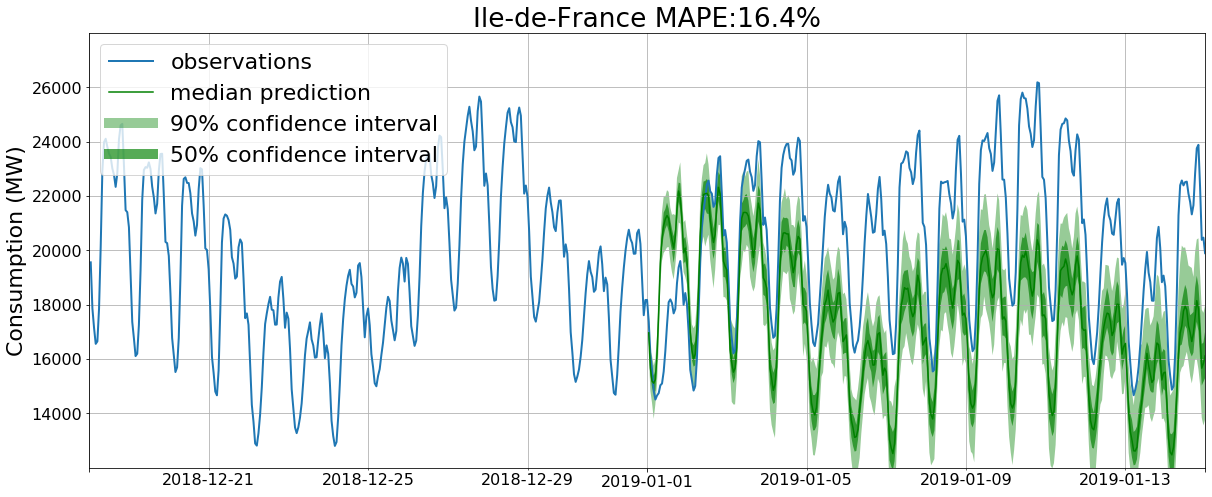

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.33it/s, avg_epoch_loss=10.8]
INFO:root:Epoch[0] Elapsed time 37.550 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.766518
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.68]
INFO:root:Epoch[1] Elapsed time 33.090 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.683995
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.77]
INFO:root:Epoch[2] Elapsed time 33.394 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.768894
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.44]
INFO:root:Epoch[3] Elapsed time 33.336 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.440821
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.251439
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[37] Elapsed time 32.751 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.252042
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[38] Elapsed time 32.880 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.240856
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[39] Elapsed time 32.851 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.234926
INFO:root:Loading parameters from best epoch (39)
INFO:root:Final loss: 7.234925584793091 (occurred at epoch 39)
INFO:root:End model training


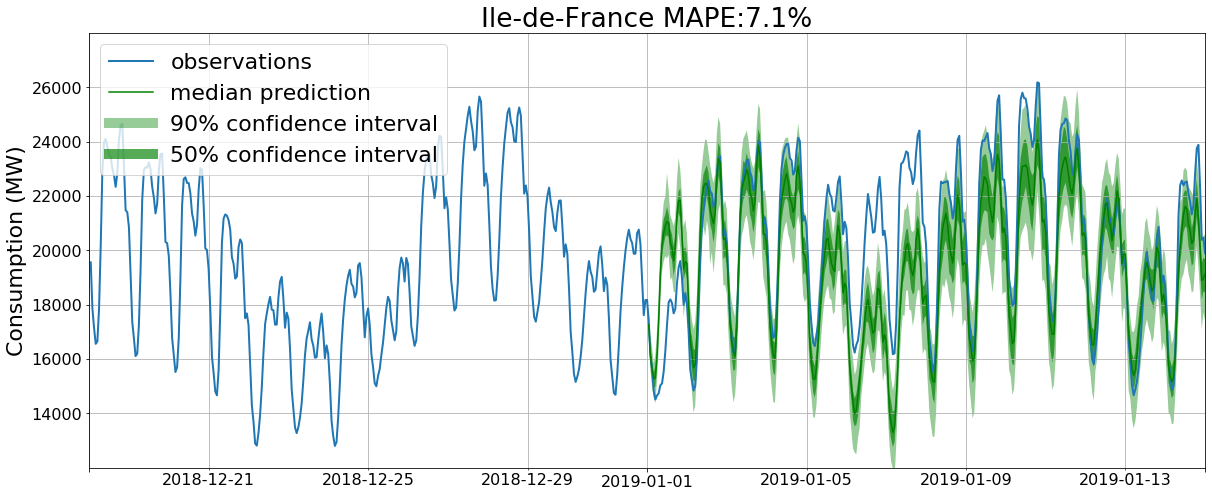

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:36<00:00,  1.35it/s, avg_epoch_loss=10.2]
INFO:root:Epoch[0] Elapsed time 36.985 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.220444
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=9.22]
INFO:root:Epoch[1] Elapsed time 32.958 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.219978
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=8.71]
INFO:root:Epoch[2] Elapsed time 32.847 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.709447
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=8.42]
INFO:root:Epoch[3] Elapsed time 33.688 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.422229
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.322652
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[37] Elapsed time 32.496 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.316308
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.3] 
INFO:root:Epoch[38] Elapsed time 32.976 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.301336
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[39] Elapsed time 32.852 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.285399
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[40] Elapsed time 33.192 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.278904
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

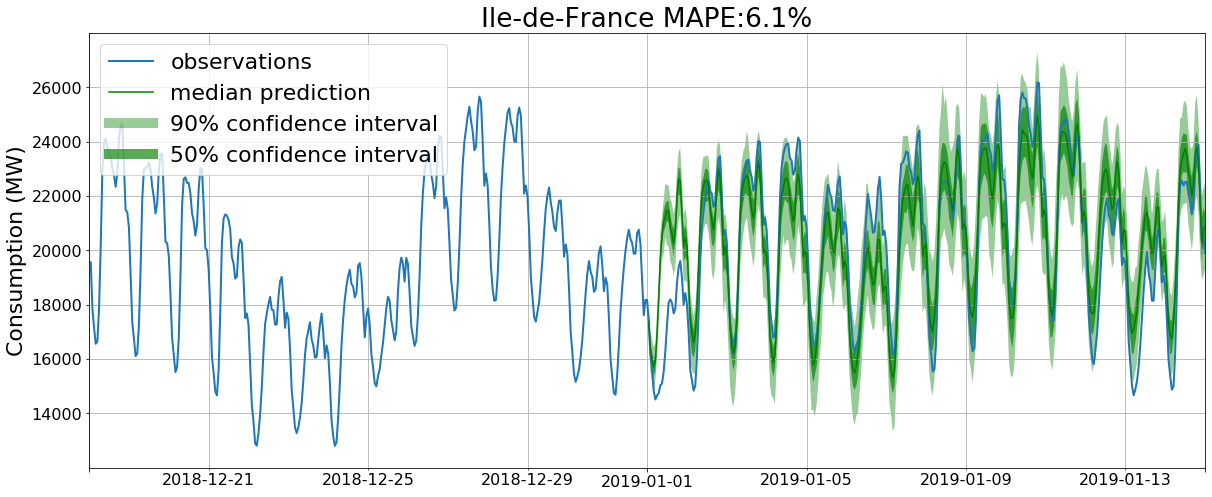

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.34it/s, avg_epoch_loss=9.88]
INFO:root:Epoch[0] Elapsed time 37.222 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.883837
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=9.38]
INFO:root:Epoch[1] Elapsed time 32.807 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.384395
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=9.08]
INFO:root:Epoch[2] Elapsed time 32.851 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.081978
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=8.76]
INFO:root:Epoch[3] Elapsed time 32.919 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.757918
INFO:root:Epoc

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.246940
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[37] Elapsed time 32.972 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.237140
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[38] Elapsed time 32.638 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.231989
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[39] Elapsed time 32.898 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.208679
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[40] Elapsed time 32.621 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.193496
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[74] Elapsed time 32.573 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.912668
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.9] 
INFO:root:Epoch[75] Elapsed time 33.029 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.904497
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[76] Elapsed time 32.553 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.887289
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=6.9] 
INFO:root:Epoch[77] Elapsed time 32.507 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.897440
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.88]
INF

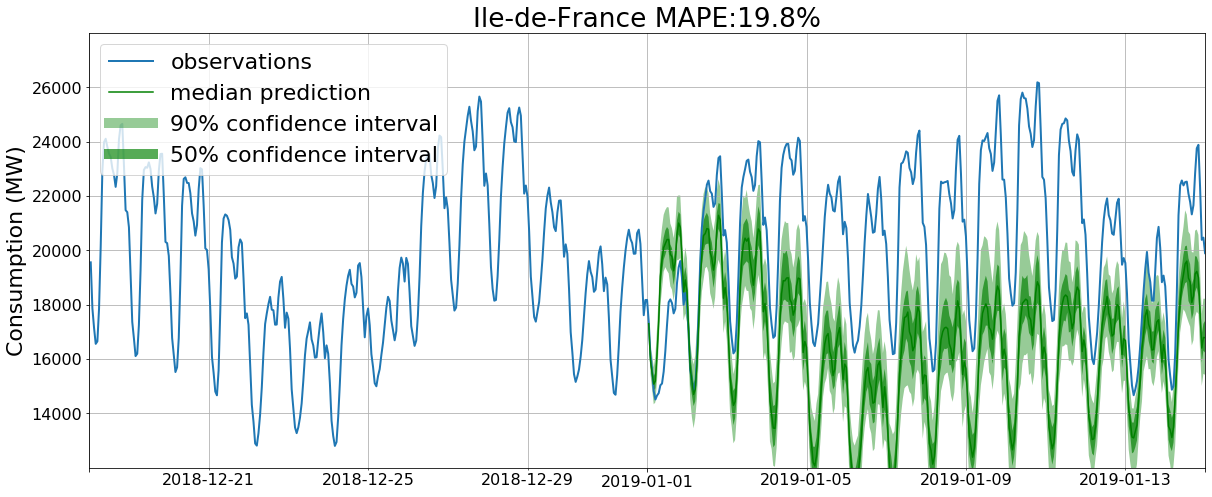

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.33it/s, avg_epoch_loss=11.1]
INFO:root:Epoch[0] Elapsed time 37.500 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=11.053326
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.91]
INFO:root:Epoch[1] Elapsed time 33.161 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.906938
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=8.81]
INFO:root:Epoch[2] Elapsed time 33.166 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.811982
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=8.5] 
INFO:root:Epoch[3] Elapsed time 32.865 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.500223
INFO:root:Epo

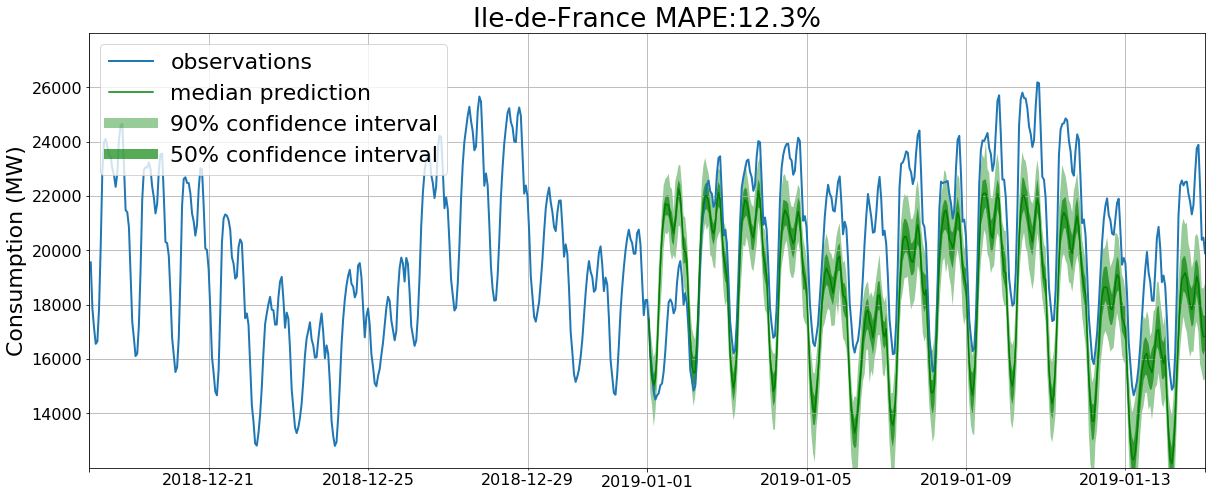

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.34it/s, avg_epoch_loss=10.6]
INFO:root:Epoch[0] Elapsed time 37.449 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.557563
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.48]
INFO:root:Epoch[1] Elapsed time 33.143 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.475656
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.99]
INFO:root:Epoch[2] Elapsed time 33.269 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.988967
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=8.65]
INFO:root:Epoch[3] Elapsed time 33.089 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.645906
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.251150
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[37] Elapsed time 32.835 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.241426
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[38] Elapsed time 32.967 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.234625
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[39] Elapsed time 33.743 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.219813
INFO:root:Loading parameters from best epoch (39)
INFO:root:Final loss: 7.219813289642334 (occurred at epoch 39)
INFO:root:End model training


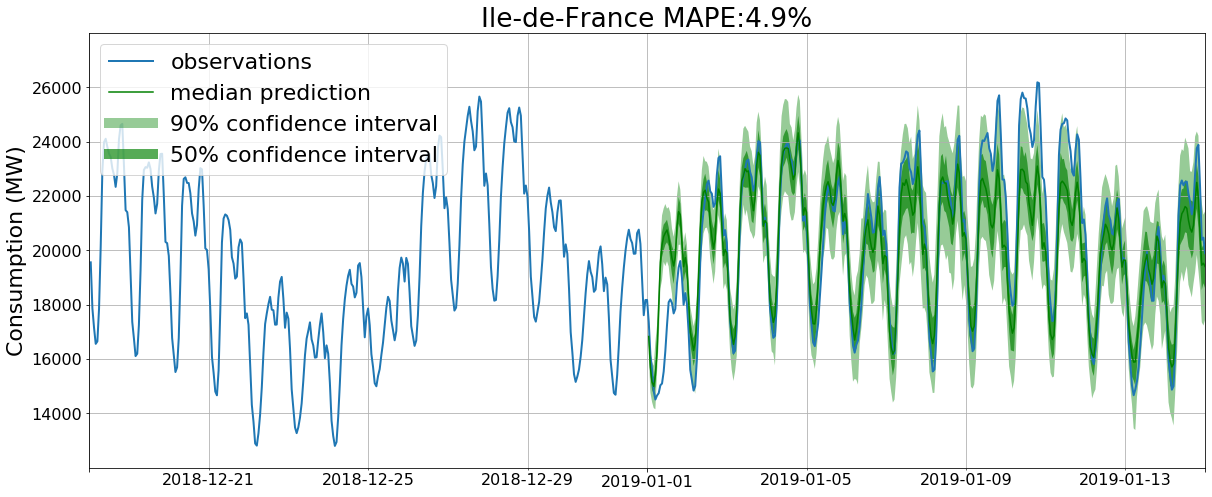

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.34it/s, avg_epoch_loss=10.1]
INFO:root:Epoch[0] Elapsed time 37.275 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.051949
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.08]
INFO:root:Epoch[1] Elapsed time 33.129 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.083313
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=8.73]
INFO:root:Epoch[2] Elapsed time 32.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.732643
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.55]
INFO:root:Epoch[3] Elapsed time 33.279 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.550483
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.365641
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[37] Elapsed time 33.187 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.329022
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[38] Elapsed time 33.301 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.334090
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[39] Elapsed time 32.966 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.334436
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[40] Elapsed time 32.893 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.315615
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

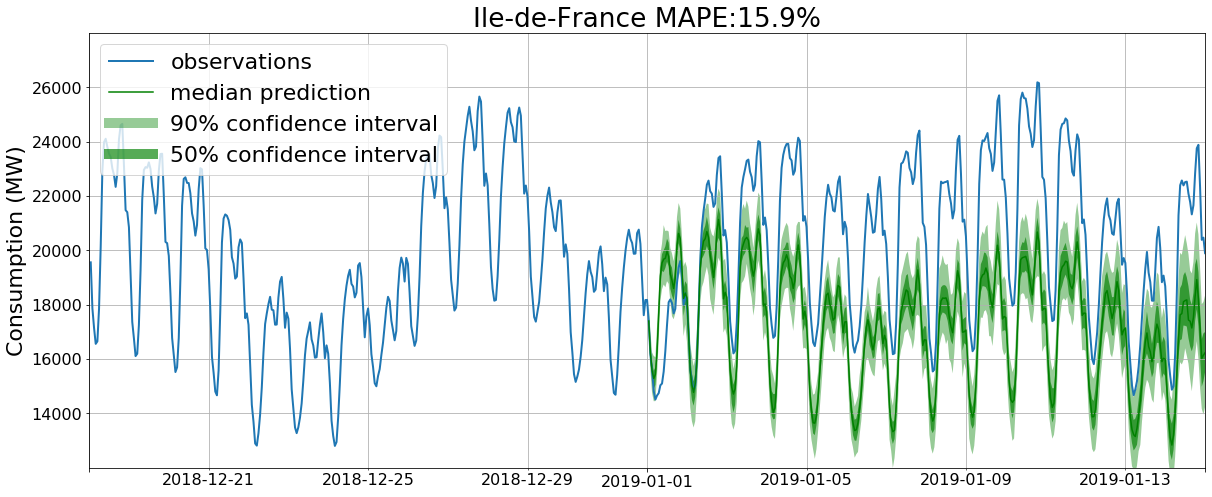

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.32it/s, avg_epoch_loss=10.3]
INFO:root:Epoch[0] Elapsed time 37.777 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.277930
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.33]
INFO:root:Epoch[1] Elapsed time 33.213 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.325707
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=8.84]
INFO:root:Epoch[2] Elapsed time 33.040 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.844938
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=8.65]
INFO:root:Epoch[3] Elapsed time 33.511 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.654827
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.245191
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[37] Elapsed time 33.561 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.231752
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[38] Elapsed time 33.230 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.228635
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[39] Elapsed time 33.325 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.216582
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=7.2] 
INFO:root:Epoch[40] Elapsed time 33.748 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.200409
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[74] Elapsed time 33.058 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.957761
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[75] Elapsed time 32.779 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.969083
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[76] Elapsed time 33.492 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.947994
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[77] Elapsed time 33.365 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.947895
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=6.94]
INF

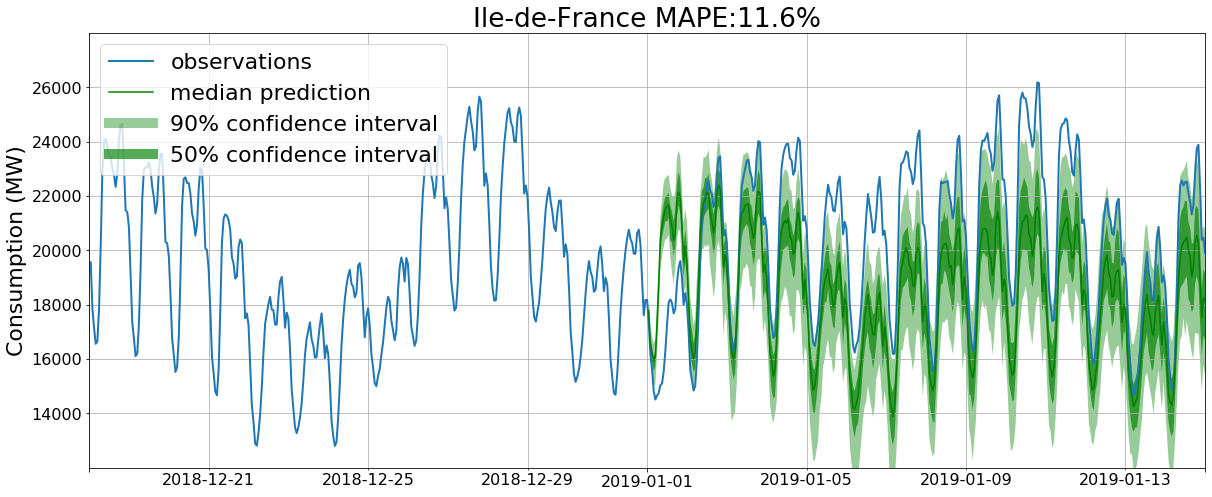

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:38<00:00,  1.31it/s, avg_epoch_loss=10.6]
INFO:root:Epoch[0] Elapsed time 38.042 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.552250
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.35]
INFO:root:Epoch[1] Elapsed time 33.116 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.352869
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=9.01]
INFO:root:Epoch[2] Elapsed time 33.225 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.012396
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=8.77]
INFO:root:Epoch[3] Elapsed time 33.181 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.772542
INFO:root:Epo

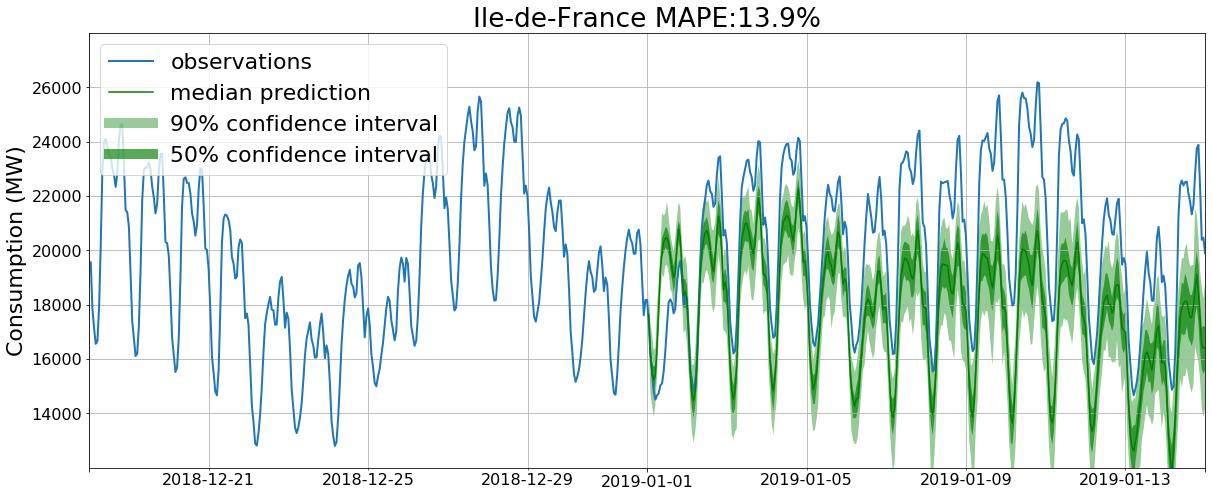

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.33it/s, avg_epoch_loss=9.97]
INFO:root:Epoch[0] Elapsed time 37.614 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.965387
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=9.13]
INFO:root:Epoch[1] Elapsed time 33.642 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.129011
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=8.76]
INFO:root:Epoch[2] Elapsed time 33.484 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.758899
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=8.55]
INFO:root:Epoch[3] Elapsed time 33.586 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.552198
INFO:root:Epoc

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.178389
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[37] Elapsed time 33.529 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.143334
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[38] Elapsed time 33.729 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.161783
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[39] Elapsed time 33.470 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.138990
INFO:root:Loading parameters from best epoch (39)
INFO:root:Final loss: 7.138989953994751 (occurred at epoch 39)
INFO:root:End model training


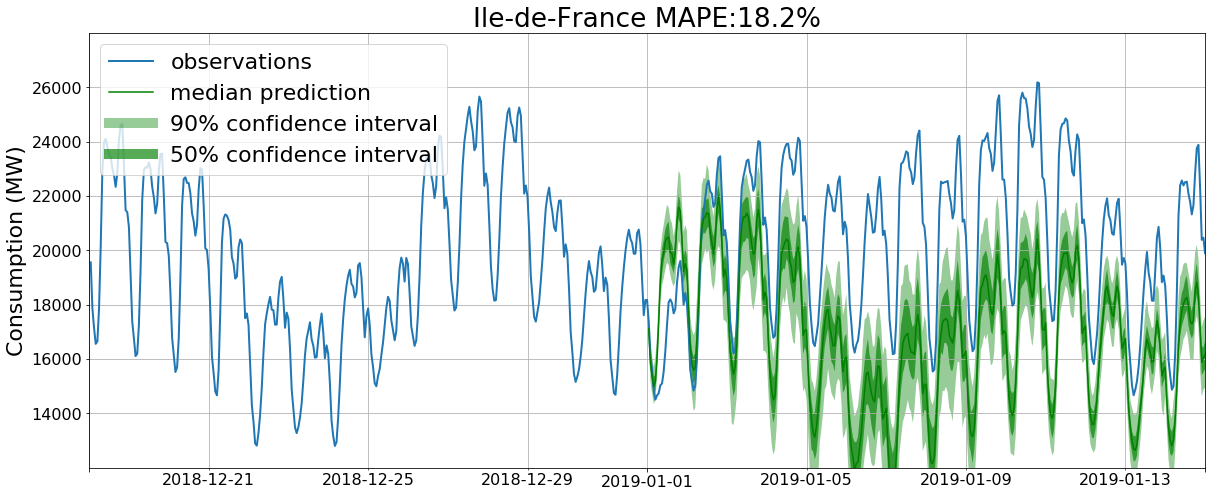

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.33it/s, avg_epoch_loss=10]  
INFO:root:Epoch[0] Elapsed time 37.566 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.014470
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=9.22]
INFO:root:Epoch[1] Elapsed time 33.488 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.220151
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.72]
INFO:root:Epoch[2] Elapsed time 33.323 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.720243
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.42]
INFO:root:Epoch[3] Elapsed time 33.396 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.416035
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.297517
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[37] Elapsed time 32.781 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.293787
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[38] Elapsed time 33.133 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.283391
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[39] Elapsed time 33.063 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.281458
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[40] Elapsed time 33.071 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.268954
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

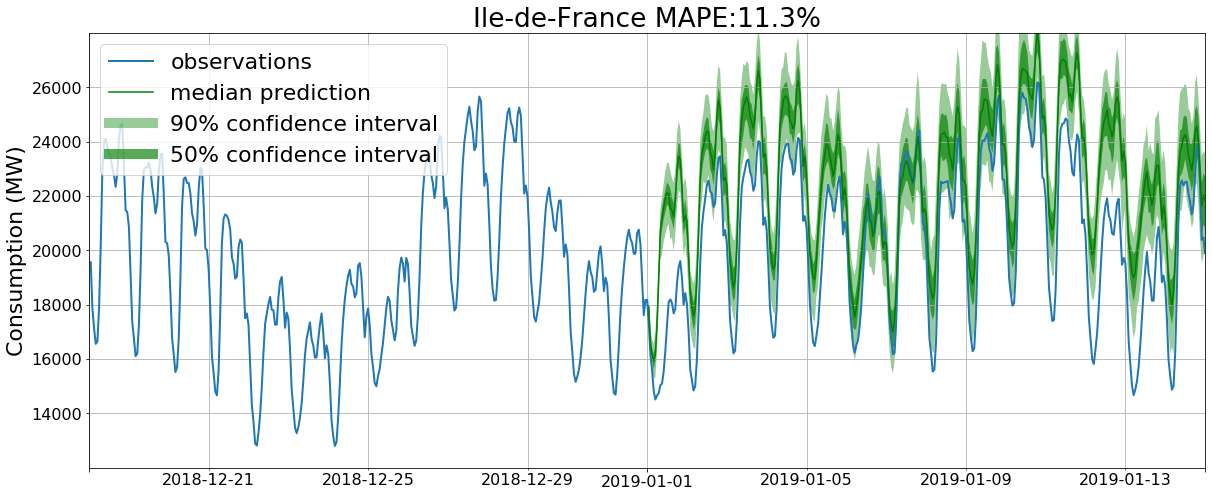

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.34it/s, avg_epoch_loss=11.6]
INFO:root:Epoch[0] Elapsed time 37.445 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=11.597935
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.88]
INFO:root:Epoch[1] Elapsed time 33.218 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.883850
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=9.28]
INFO:root:Epoch[2] Elapsed time 33.464 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.280015
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=8.87]
INFO:root:Epoch[3] Elapsed time 33.448 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.872802
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.266479
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[37] Elapsed time 33.503 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.251487
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[38] Elapsed time 33.102 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.233866
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[39] Elapsed time 33.478 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.244641
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[40] Elapsed time 33.322 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.216451
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7]   
INFO:root:Epoch[74] Elapsed time 33.530 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.003052
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[75] Elapsed time 33.198 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.994990
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[76] Elapsed time 33.015 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.984767
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[77] Elapsed time 33.432 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.979180
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=6.98]
INF

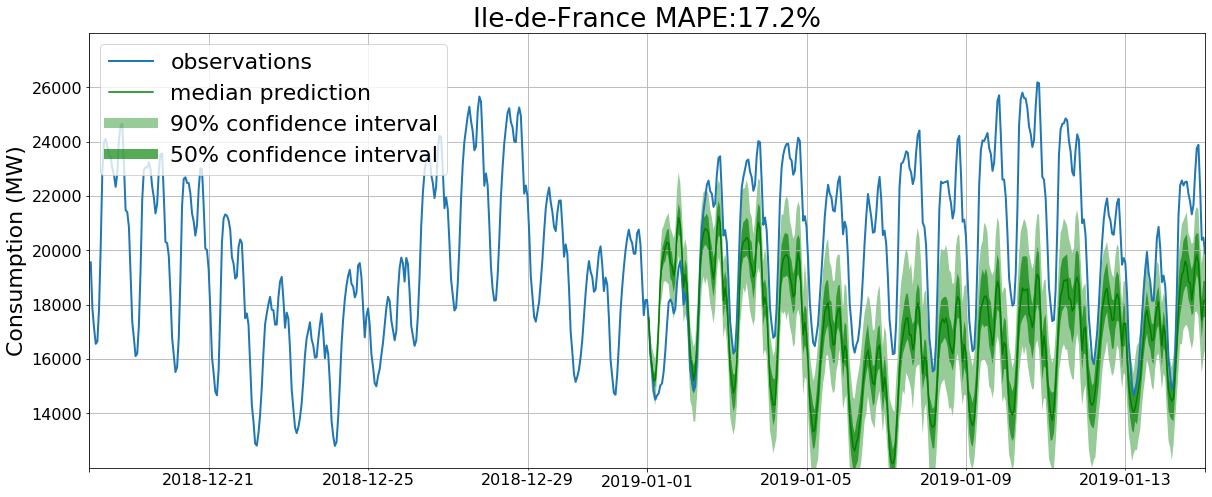

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:38<00:00,  1.31it/s, avg_epoch_loss=9.85]
INFO:root:Epoch[0] Elapsed time 38.108 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.854770
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.77]
INFO:root:Epoch[1] Elapsed time 33.436 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.769314
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[2] Elapsed time 33.314 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.394310
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=8.22]
INFO:root:Epoch[3] Elapsed time 33.583 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.219507
INFO:root:Epoc

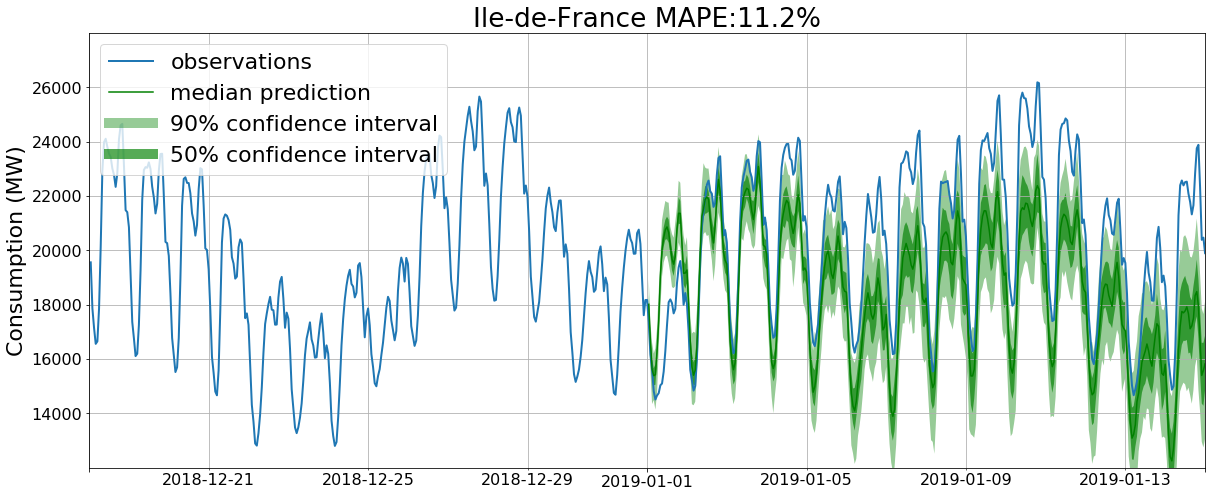

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.33it/s, avg_epoch_loss=10.8]
INFO:root:Epoch[0] Elapsed time 37.530 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.795655
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=9.63]
INFO:root:Epoch[1] Elapsed time 33.655 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.634706
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=9.04]
INFO:root:Epoch[2] Elapsed time 33.736 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.036992
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=8.71]
INFO:root:Epoch[3] Elapsed time 33.670 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.705965
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.310339
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[37] Elapsed time 33.424 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.288198
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[38] Elapsed time 33.694 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.280849
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[39] Elapsed time 33.610 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.257126
INFO:root:Loading parameters from best epoch (39)
INFO:root:Final loss: 7.257126064300537 (occurred at epoch 39)
INFO:root:End model training


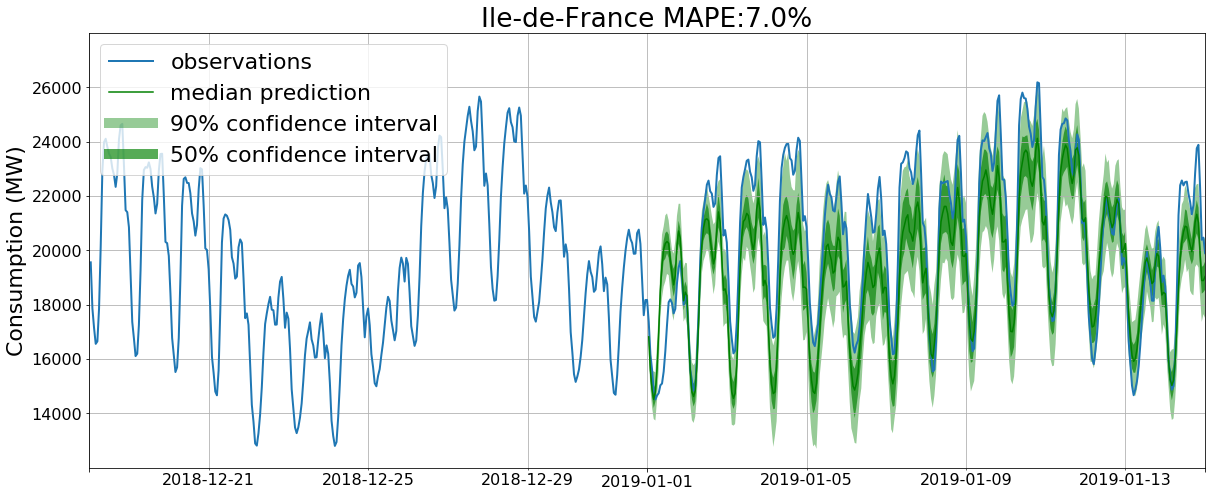

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.32it/s, avg_epoch_loss=10.4]
INFO:root:Epoch[0] Elapsed time 37.867 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.402983
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=9.32]
INFO:root:Epoch[1] Elapsed time 33.484 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.320063
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.8] 
INFO:root:Epoch[2] Elapsed time 33.243 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.798283
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=8.52]
INFO:root:Epoch[3] Elapsed time 33.472 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.524263
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.151413
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[37] Elapsed time 33.226 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.137120
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:34<00:00,  1.47it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[38] Elapsed time 34.106 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.128578
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[39] Elapsed time 33.826 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.122405
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[40] Elapsed time 33.810 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.122512
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

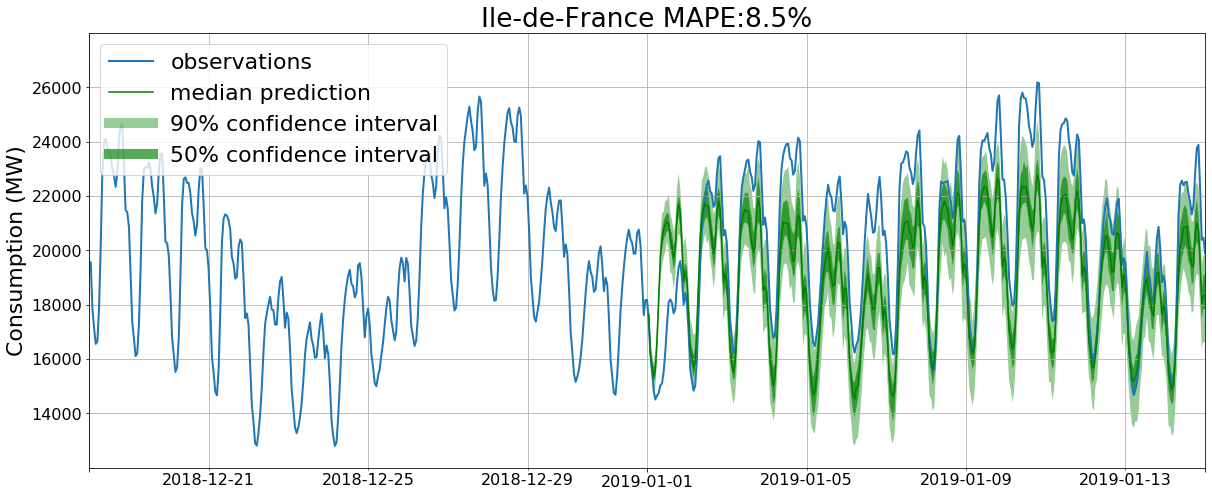

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.32it/s, avg_epoch_loss=11.6]
INFO:root:Epoch[0] Elapsed time 37.824 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=11.629663
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.48it/s, avg_epoch_loss=10.4]
INFO:root:Epoch[1] Elapsed time 33.679 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=10.368824
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=9.45]
INFO:root:Epoch[2] Elapsed time 33.626 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.452167
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=8.94]
INFO:root:Epoch[3] Elapsed time 33.401 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.943819
INFO:root:Ep

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.239672
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[37] Elapsed time 33.519 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.215359
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[38] Elapsed time 33.487 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.224486
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[39] Elapsed time 33.529 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.191191
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.2] 
INFO:root:Epoch[40] Elapsed time 33.277 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.196700
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[74] Elapsed time 33.246 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.978206
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[75] Elapsed time 33.112 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.964024
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[76] Elapsed time 33.595 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.957336
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[77] Elapsed time 33.010 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.958660
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=6.96]
INF

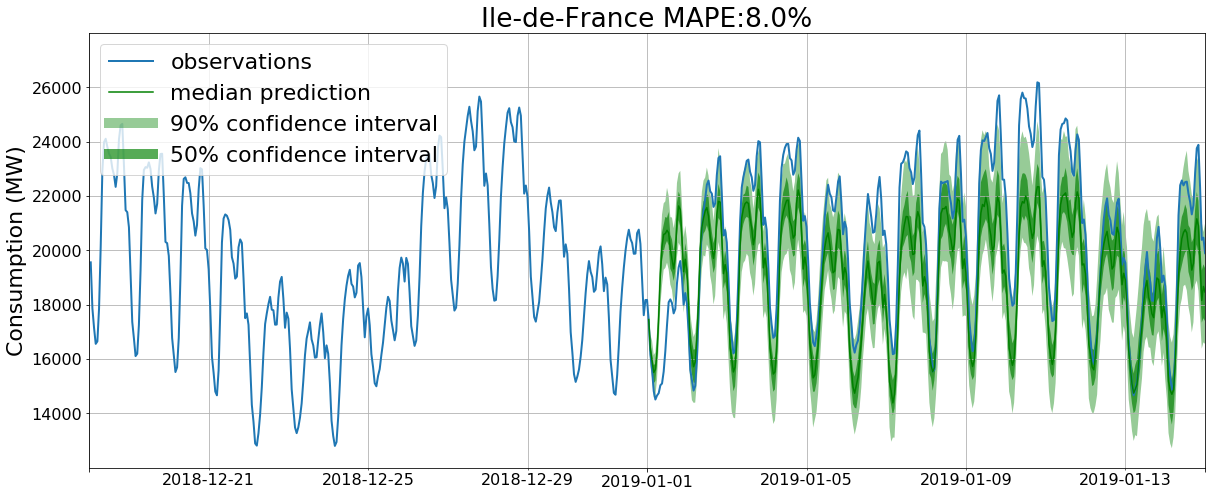

In [8]:
idf_list = ["Ile-de-France"]

for i in range(5, 10):
    for max_epochs in [20, 40, 60, 80]:
        idf_predictor = train_predictor(df_dict, end_train_date, idf_list, max_epochs=max_epochs,
                                        target_col="Consommation (MW)", feat_dynamic_cols=None)
        
        matplotlib.rcParams.update({'font.size': 22})
        forecasts, tss = make_predictions(idf_predictor, df_dict, test_date, idf_list,
                                          target_col="Consommation (MW)")
        MAPE = plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1,
                       figname="./deepar_stability_study/figures/{}_epochs_trial_{}.png".format(max_epochs, i+1))
        
        result_df = pd.DataFrame.from_records([{"max_epochs": max_epochs, "MAPE": MAPE, "trial_nb": i+1}])
        
        try:
            existing_results = pd.read_csv("./deepar_stability_study/results.csv")
        except:
            existing_results = None
        
        final_results = pd.concat([existing_results, result_df])
        
        final_results.to_csv("./deepar_stability_study/results.csv", index=False)
        